## Challenge Resume

This notebook contains work on a data challenge aiming to detect anomalies in time series. The time series correspond to accelerations from Airbus Aircrafts. 

1. **Data exploration** 

We will first take a look at the different accelerations from both our train and test data, plotting random observations then taking a look a statistics on these. This first step will allow us to notice that:

    * train and test observations seem to differ 
    * observation can seem to show located anomalies.


2. **Clustering** 

To look more into the train and test data difference we will then use a K means clustering algorithm. With 5 clusters, it will classify all training data in one, about 96% of test data and that same one and the rest of test data pretty uniformly in the four others. This is interesting in two ways : 
    * it looks like our first intuition was correct and that train data doesn't contain abnormal samples this will help us in calibrating our anomaly detection algorithms with a low contamination rate, 
    * the rest of the data is in four classes making us think that abnormalities can manifest in different ways.
We tried using the clusterisation as a feature but this did not improve our models. (No impact).


3. **Functional Isolation Forest**

Before starting feature engineering, we tried the Functional Isolation Forest algorithm with the code provided on Guillaume Staermann's github (See bibliographie for all reference and adapted code). This took a few hours, up to 40Go of RAM and gave a score under 0.75. By lack of time this algorithm being very time consumming, we did not come back to this article and algorithm, but it would have been interesting to take another look at it cutting down the signals into smaller ones like we did latter on or even constructing new multivariate time series with different statistics taken on small windows.


4. **Feature engineering**

Leveraging on observations made in the exploratory part, we calculated different statistics on the signals. We then ran 3 classic anomaly detection algorithms. More feature engineering was done later on on transformed data (Fourier filter, Wavelet decompositions).

5. **Anomaly Detection**

Isolation Forest, Local Outlier Factor and One Class Support Vector Machine, this last one gave higher scoring on the leader board and we decided to focus on it.


6. **OCSVM tuning and score evaluation**

We spent a lot of time reading work from Albert Thomas, Nicolas Goix and members of TSI research team from Telecom. On an unsupervised problem like this finding a way of evaluating our models seemed key. We used code from Albert Thomas's github to try and tune the algorithm, compare different sets of features (comparing sets with the same number of features) and evaluate the accuracy of a model. However, this method did not give us very different minimum volume sets and therefore was not conclusive.
We therefore used the histograms of score anomalies to choose which scores to save and submit : when score did not allow a seperation of the data or when too few points were isolated we stoped submitting those scores.


7. **Filtering training samples**

Having noticed that our train data was normal, we filtered its scores to eliminate the 10% most abnormal observation and retraining our model, considering that these observation were introducing a biais. This had a minor improvement effect and we did not reproduce this technique on following models, although it could have been interesting to test.


8. **Wavelet Transform**

We then used the wavelet coefficients of our signals to build a new set of features keeping 5th and 95th percentiles of coefficient on each wavelet scale plus the median for most dilated wavelets. We then ran a OCSVM and combined scores with scores obtained before averaging ranked scores. This gave us .84 on the leader board.

9. **Signal denoising** 

From different lectures on anomaly detection on similar data, denoising the signal in order to recover the 'real' normal density is often looked at. We therefore tried denoising the observation taking discrete Fourier
Transforms on wich we apply a filter before reconstructing the signal thanks to the inverse discrete fourier transform function.
We then took the same approach constructing features from basic statistics but on our denoised observations, this improved score to about .85. This approach also led us to adding the highest frequencies of our signal as features on our raw data approach.

10. **Window break down**

Finally we tried to exploit the difference between different windows in our signal observed in the exploraotry phasis by cutting our signal in several periods. Having a one minute signal we tried dividing it in 3 seconds than one second windows. This gave us our final score improvement with a submission score of **~.86**. We used PyOd combine_average method to ensemble scores from all windows.

11. **PyOd PCA, ensembling methods**

We also tried exploiring PyOd library,using its Principal Component analysis for Anomaly detection and ensembling methods. This last algorithm equalled our best score (~.86).

We also tried training a GAN with no success yet. With more time taking a look at PyOd's Variational Auto Encodeur as well as other anomaly detection libraries listed in repo below could have been interesting.
https://github.com/rob-med/awesome-TS-anomaly-detection

## Importation des donnees

In [1]:
# Importations des packages
# General
import pandas as pd
import numpy as np
import warnings
import random
import itertools
warnings.filterwarnings("ignore")
from sklearn.utils import check_random_state

# FPCA 
from fpca import ModelFPCA

# Preprocessing
from sklearn.preprocessing import StandardScaler, minmax_scale

# Statistics
from tsfresh import extract_features

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Exploration, decompoition
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook as tqdm
from scipy.fftpack import dct, idct, dst, idst, rfft
from numpy.fft import *

#Signal decomposition
import pywt

# Detection d'anomalies
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from pyod.models.pca import PCA

# Ranking / Evaluation
from pyod.utils.utility import standardizer
from pyod.models.combination import aom, moa, average, maximization
from scipy.stats import rankdata, kurtosis, skew
from sklearn.metrics import auc

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Importation des donnees
xtrain = np.loadtxt('airbus_train.csv', delimiter= ' ', max_rows=2000, dtype=np.float16)
print(xtrain.shape)
xtest = np.loadtxt('airbus_test.csv', delimiter= ' ',max_rows=2600 , dtype=np.float16)
print(xtest.shape)

(1677, 61440)
(2511, 61440)


In [3]:
# Check for nan values
array_sum = np.sum(xtrain)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False


In [4]:
df = pd.DataFrame(xtrain)
df_test = pd.DataFrame(xtest)

## Observations des donnees

Let's start out by checking our series for null values, and looking at the image of these signals, on the whole minute and on sub ranges.
Lets also take a look at histograms to get first intuitions on these series.

<function matplotlib.pyplot.show(*args, **kw)>

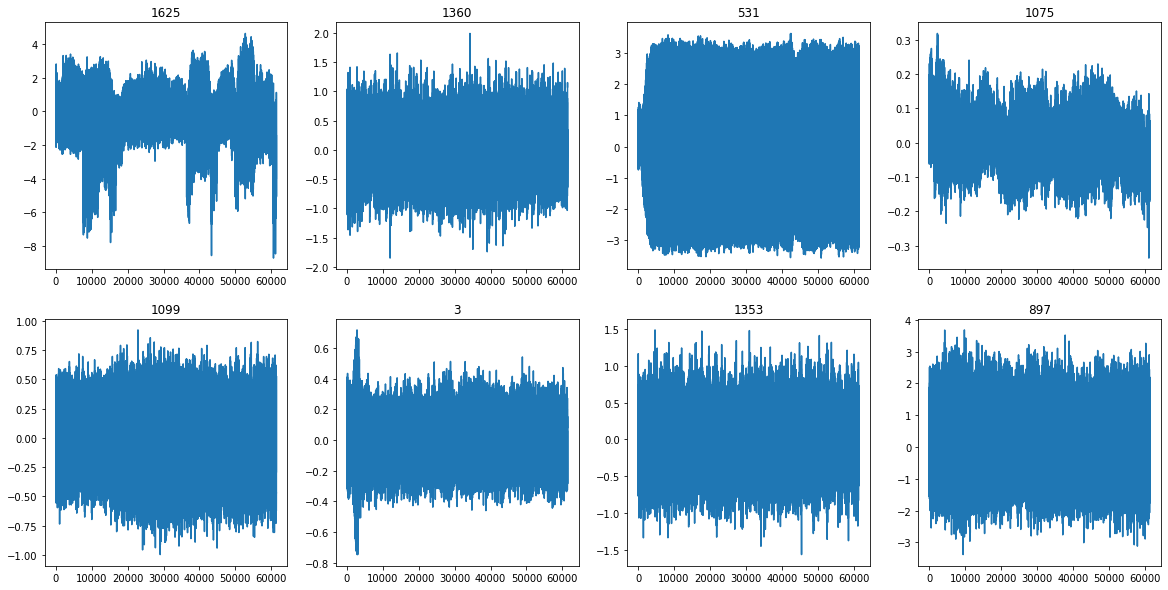

In [5]:
randomList = []
for i in range(0, 8):
    randomList.append(random.randint(0, len(xtrain)))

plt.figure(figsize=(20, 10))
plt.subplot(241)
plt.title(randomList[0])
plt.plot(xtrain[randomList[0]])
plt.subplot(242)
plt.title(randomList[1])
plt.plot(xtrain[randomList[1]])
plt.subplot(243)
plt.title(randomList[2])
plt.plot(xtrain[randomList[2]])
plt.subplot(244)
plt.title(randomList[3])
plt.plot(xtrain[randomList[3]])

plt.subplot(245)
plt.title(randomList[4])
plt.plot(xtrain[randomList[4]])
plt.subplot(246)
plt.title(randomList[5])
plt.plot(xtrain[randomList[5]])
plt.subplot(247)
plt.title(randomList[6])
plt.plot(xtrain[randomList[6]])
plt.subplot(248)
plt.title(randomList[7])
plt.plot(xtrain[randomList[7]])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

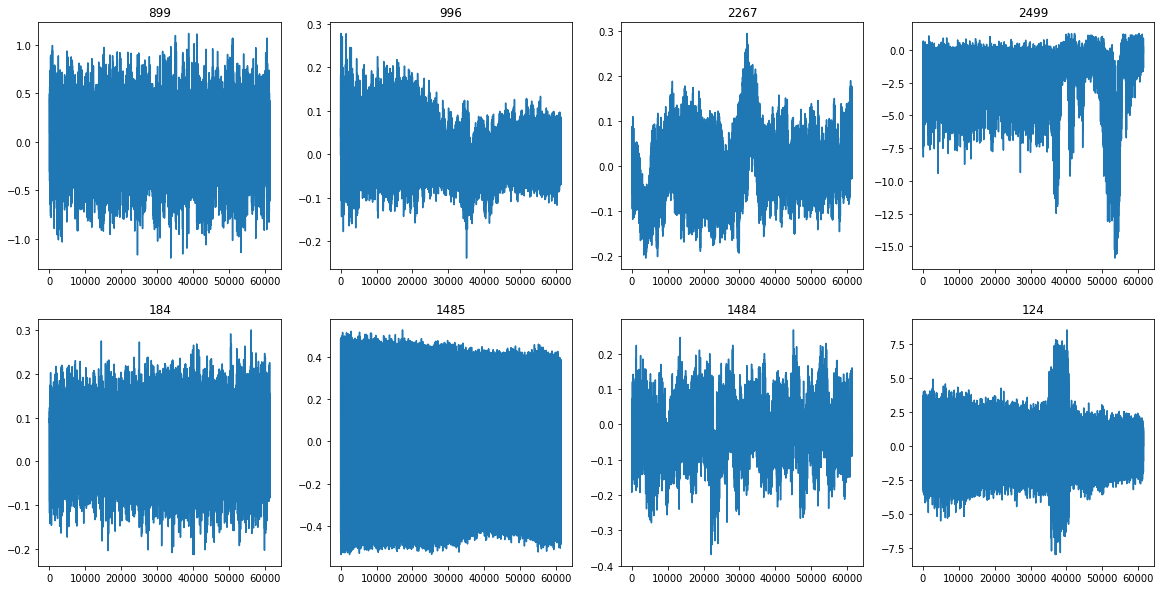

In [6]:
randomList = []
for i in range(0, 8):
    randomList.append(random.randint(0, len(xtest)))

plt.figure(figsize=(20, 10))
plt.subplot(241)
plt.title(randomList[0])
plt.plot(xtest[randomList[0]])
plt.subplot(242)
plt.title(randomList[1])
plt.plot(xtest[randomList[1]])
plt.subplot(243)
plt.title(randomList[2])
plt.plot(xtest[randomList[2]])
plt.subplot(244)
plt.title(randomList[3])
plt.plot(xtest[randomList[3]])

plt.subplot(245)
plt.title(randomList[4])
plt.plot(xtest[randomList[4]])
plt.subplot(246)
plt.title(randomList[5])
plt.plot(xtest[randomList[5]])
plt.subplot(247)
plt.title(randomList[6])
plt.plot(xtest[randomList[6]])
plt.subplot(248)
plt.title(randomList[7])
plt.plot(xtest[randomList[7]])

plt.show

Plots from train and test samples seem to be quite different, this will lead us to look at a clsutering algorithm to see if they are. Plots from some test samples also show a larger range of values.
Plots also show that some signals seem visually different only on a portion of the minute. This will lead us to a signal decomposition to try to study anomalies on portions of accelerations.
Let's take a look at different statiscal properties from the signal and check how they are distributed over both the train and test samples. 

Histogramme of medians from each set (train/test).

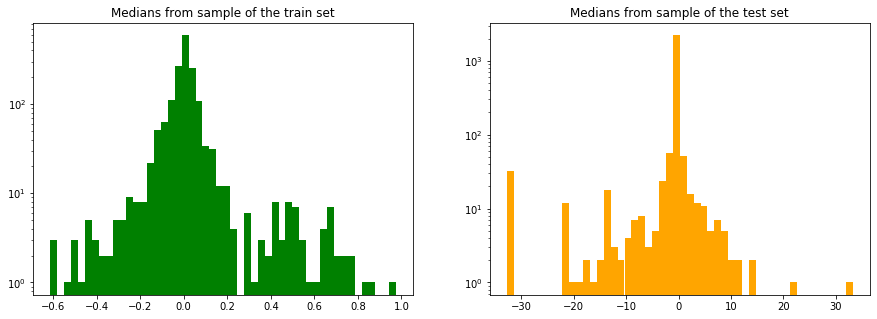

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Medians from sample of the train set")
plt.hist(np.median(xtrain, axis=1), bins=50, color="green", log=True)

plt.subplot(122)
plt.title("Medians from sample of the test set")
plt.hist(np.median(xtest, axis=1), bins=50, color="orange", log=True)
plt.show()

Medians of train samples are concentrated within abs(1), on test samples they can take much larger and smaller values.

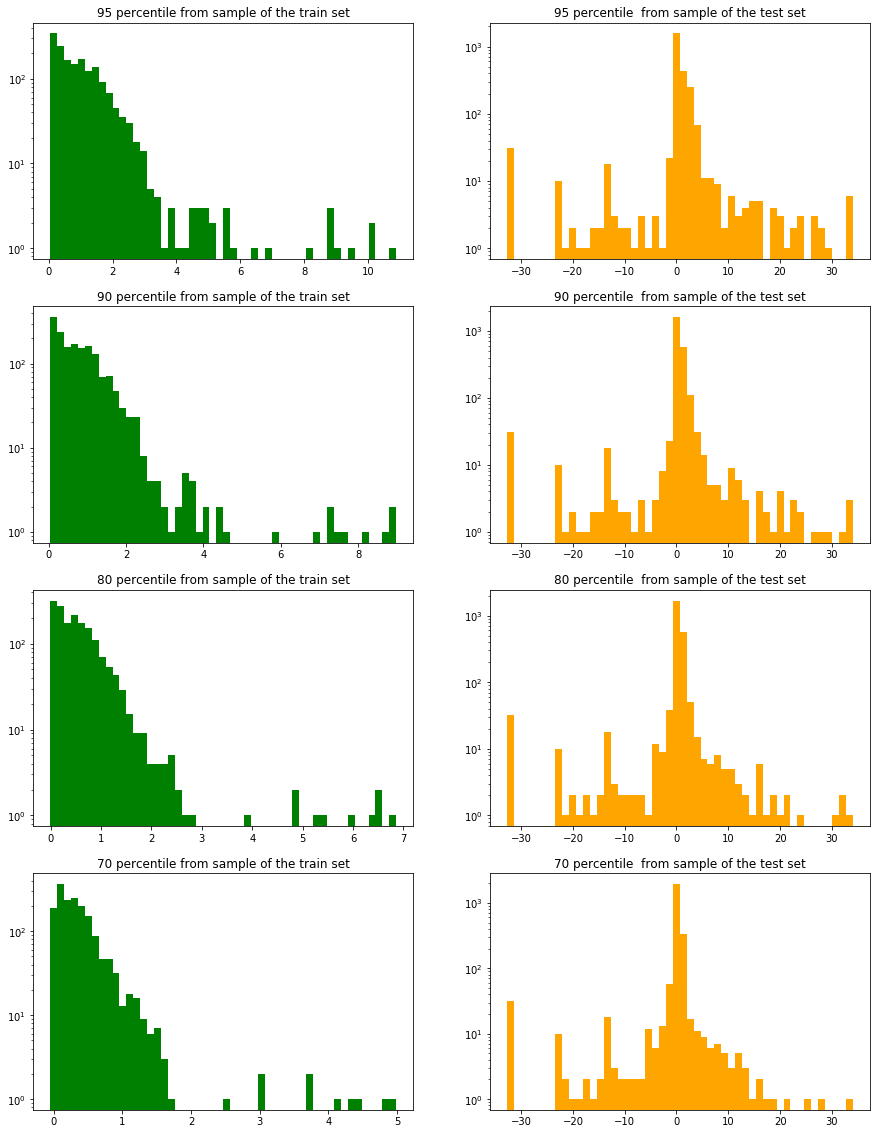

In [8]:
plt.figure(figsize=(15, 20))
plt.subplot(421)
plt.title("95 percentile from sample of the train set")
plt.hist(np.percentile(xtrain, 95, axis=1), bins=50, color="green", log=True)
plt.subplot(422)
plt.title("95 percentile  from sample of the test set")
plt.hist(np.percentile(xtest, 95, axis=1), bins=50, color="orange", log=True)

plt.subplot(423)
plt.title("90 percentile from sample of the train set")
plt.hist(np.percentile(xtrain, 90, axis=1), bins=50, color="green", log=True)
plt.subplot(424)
plt.title("90 percentile  from sample of the test set")
plt.hist(np.percentile(xtest, 90, axis=1), bins=50, color="orange", log=True)

plt.subplot(425)
plt.title("80 percentile from sample of the train set")
plt.hist(np.percentile(xtrain, 80, axis=1), bins=50, color="green", log=True)
plt.subplot(426)
plt.title("80 percentile  from sample of the test set")
plt.hist(np.percentile(xtest, 80, axis=1), bins=50, color="orange", log=True)

plt.subplot(427)
plt.title("70 percentile from sample of the train set")
plt.hist(np.percentile(xtrain, 70, axis=1), bins=50, color="green", log=True)
plt.subplot(428)
plt.title("70 percentile  from sample of the test set")
plt.hist(np.percentile(xtest, 70, axis=1), bins=50, color="orange", log=True)
plt.show()

70th percentile seems to concentrate train values better. All these percentiles show an interesting distribution over test set.

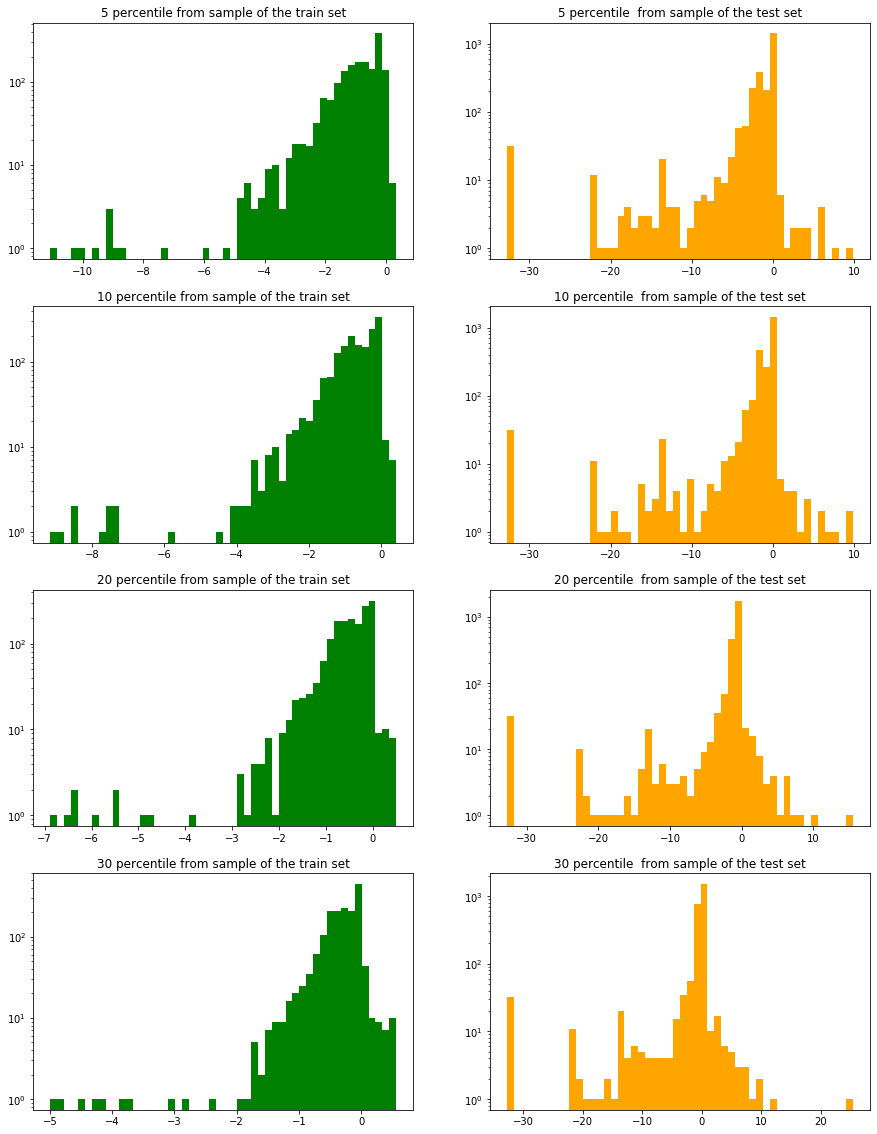

In [9]:
plt.figure(figsize=(15, 20))
plt.subplot(421)
plt.title("5 percentile from sample of the train set")
plt.hist(np.percentile(xtrain, 5, axis=1), bins=50, color="green", log=True)
plt.subplot(422)
plt.title("5 percentile  from sample of the test set")
plt.hist(np.percentile(xtest, 5, axis=1), bins=50, color="orange", log=True)

plt.subplot(423)
plt.title("10 percentile from sample of the train set")
plt.hist(np.percentile(xtrain, 10, axis=1), bins=50, color="green", log=True)
plt.subplot(424)
plt.title("10 percentile  from sample of the test set")
plt.hist(np.percentile(xtest, 10, axis=1), bins=50, color="orange", log=True)

plt.subplot(425)
plt.title("20 percentile from sample of the train set")
plt.hist(np.percentile(xtrain, 20, axis=1), bins=50, color="green", log=True)
plt.subplot(426)
plt.title("20 percentile  from sample of the test set")
plt.hist(np.percentile(xtest, 20, axis=1), bins=50, color="orange", log=True)

plt.subplot(427)
plt.title("30 percentile from sample of the train set")
plt.hist(np.percentile(xtrain, 30, axis=1), bins=50, color="green", log=True)
plt.subplot(428)
plt.title("30 percentile  from sample of the test set")
plt.hist(np.percentile(xtest, 30, axis=1), bins=50, color="orange", log=True)
plt.show()

30 or 20 percentile seem the most interesting to differenciate train and certain test samples.

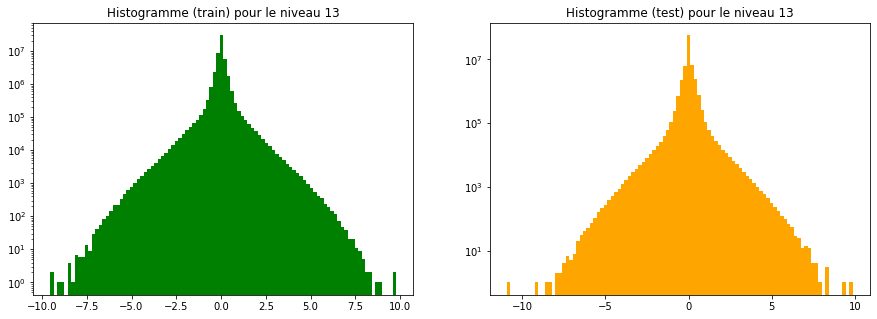

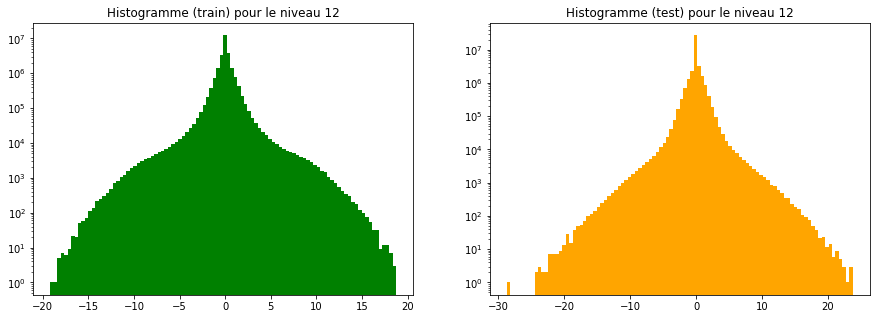

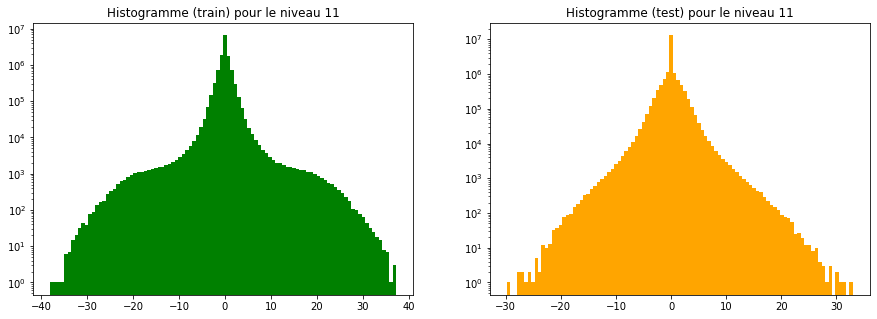

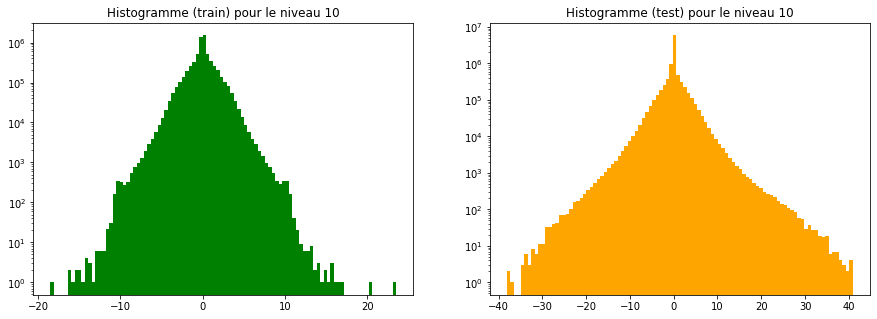

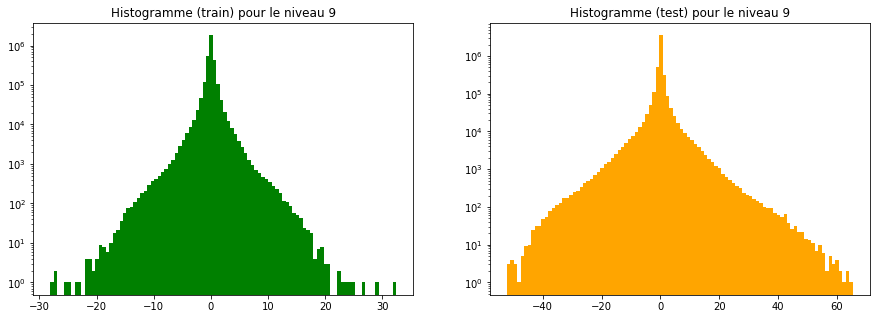

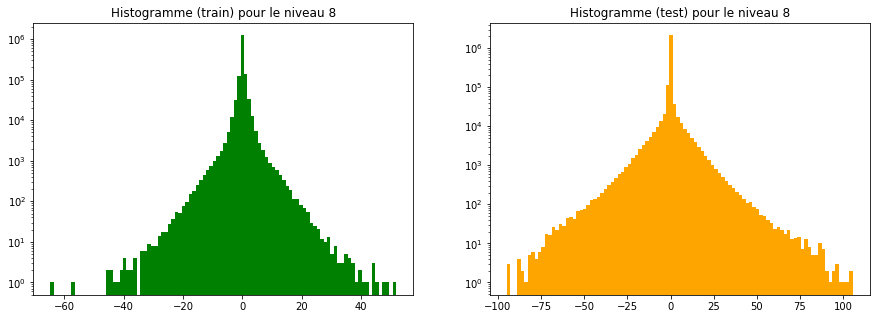

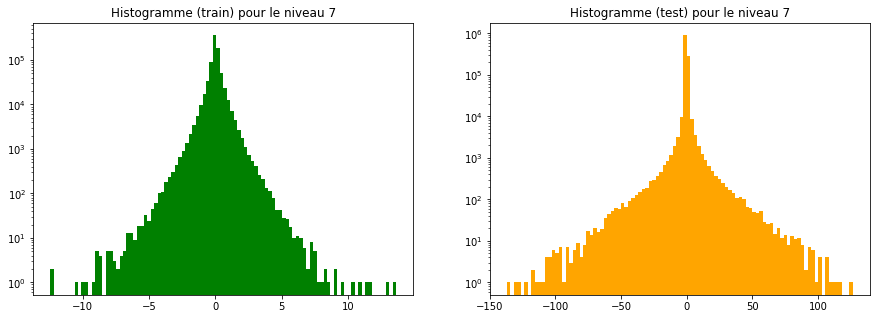

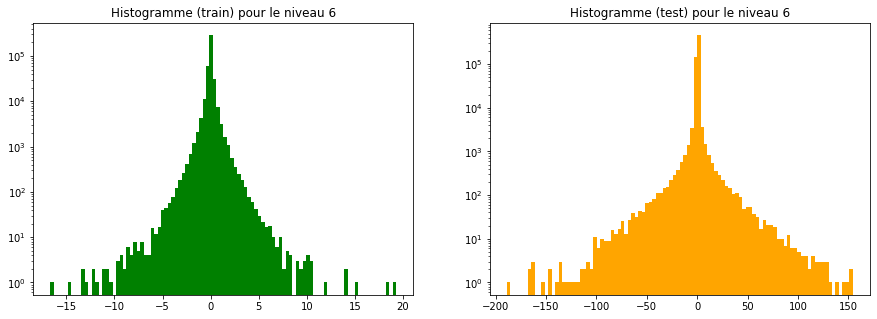

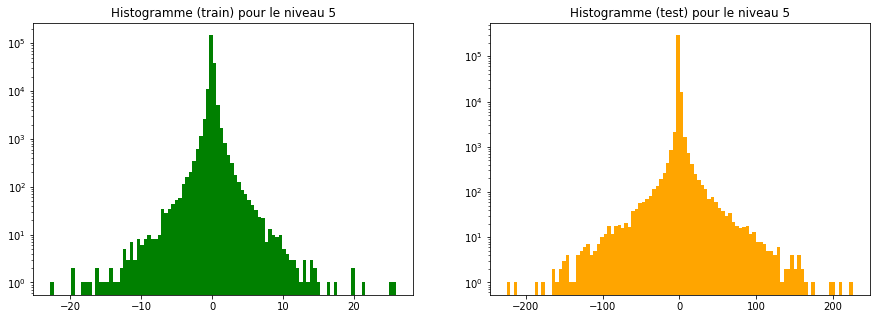

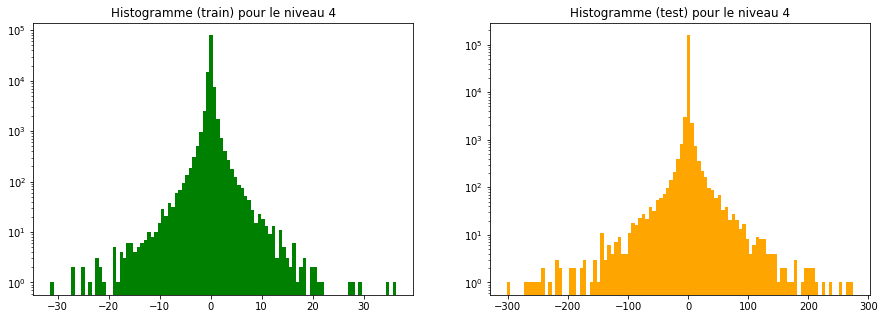

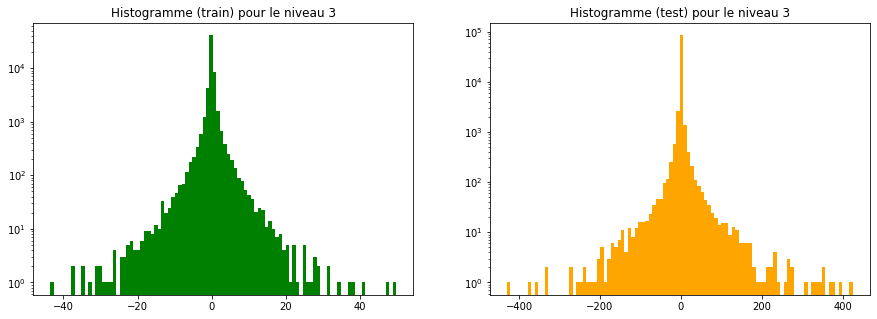

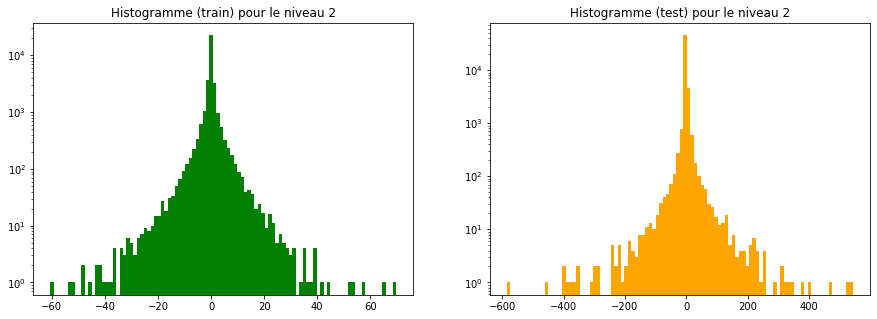

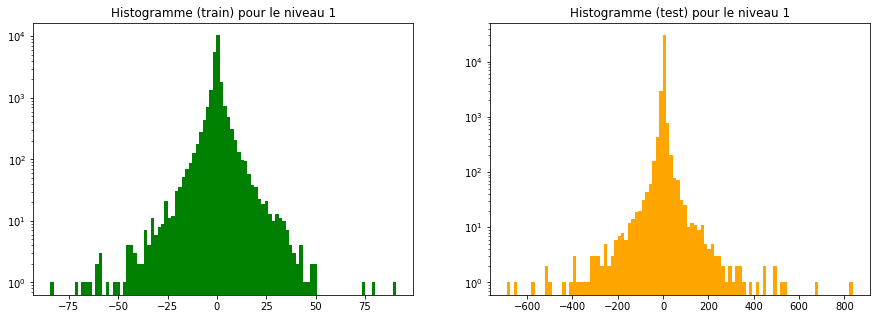

In [10]:
wavelet_window = len(xtrain[0])
w = pywt.Wavelet('sym4')
# Max decomposition level.
maxlev = pywt.dwt_max_level(wavelet_window, w.dec_len)  
wavelet_coefficients, wavelet_coefficients_test = [], []

for obs in range(len(xtrain)):
    # Processing wavelet decomposition
    signal = xtrain[obs]
    coefficients = pywt.wavedec(signal, wavelet=w, level=maxlev)    
    # Store the coefficients
    wavelet_coefficients.append(coefficients)
    
for obs in range(len(xtest)):
    # Processing wavelet decomposition
    signal = xtest[obs]
    coefficients = pywt.wavedec(signal, wavelet=w, level=maxlev)    
    # Store the coefficients
    wavelet_coefficients_test.append(coefficients)
    
# Compute the distribution for each level, starting by the most important freq one
for i in range (13,0,-1):
    c, c_test = [], []    
    for coeffs in wavelet_coefficients:
        for j in range(len(coeffs[i])):
            c.append(coeffs[i][j])
    c = np.asarray(c)
    
    for coeffs in wavelet_coefficients_test:
        for j in range(len(coeffs[i])):
            c_test.append(coeffs[i][j])
    c_test = np.asarray(c_test)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.hist(c, bins=100, log=True, color='green')
    plt.title("Histogramme (train) pour le niveau "+str(i), fontsize=12)
    plt.subplot(122)
    plt.hist(c_test, bins=100, log=True, color='orange')
    plt.title("Histogramme (test) pour le niveau "+str(i), fontsize=12)
    plt.show()

Distribution's look alike with high peak around 0, yet the extreme values from some test sample are quite larger than the maximums on train samples.

## Clustering - using Kmeans algorithm

In [11]:
#Let's run a Kmeans on all the data (train and test combined) to see where train and test samples end.
alldata = np.concatenate((xtrain, xtest), axis=0)
kmeans_alldata = KMeans(n_clusters=5, random_state=0).fit_predict(alldata)
kmeans_pred = KMeans(n_clusters=5, random_state=0).fit(xtrain).predict(xtest)
print(np.unique(kmeans_alldata, return_counts=True))


(array([0, 1, 2, 3, 4], dtype=int32), array([4052,   18,   40,   47,   31]))


In [14]:
df_kmeans_train = kmeans_alldata[:1677]
df_kmeans_test = kmeans_alldata[1677:] 
kmeans_alldata_01 = [0 if kmeans_alldata[obs]==0 else 1 for obs in range(len(alldata))]


In [13]:
print(np.unique(kmeans_alldata_01, return_counts=True))
print(np.unique(df_kmeans_train, return_counts=True))
print(np.unique(df_kmeans_test, return_counts=True))

(array([0, 1]), array([4052,  136]))
(array([0], dtype=int32), array([1677]))
(array([0, 1, 2, 3, 4], dtype=int32), array([2375,   18,   40,   47,   31]))


K means clustering gathers all training samples in one cluster along with 94.6% of the test samples. Only 136 test samples are seperated in other clusters, this portion is well split between the 4 other clusters which can lead one to think that there are different kinds of abnormalities possible. A feature was created using this clusterisation but it did not improve score (no positive nor negative impact).

## Extract statictical features from observations

In [15]:
def count_values_in_range(series, range_min, range_max):
    # Source : https://datascience.stackexchange.com/questions/29671/
    # "between" returns a boolean Series equivalent to left <= series <= right.
    # NA values will be treated as False.
    return series.between(left=range_min, right=range_max).sum()



In [16]:
def categorise_mean(mean):
    if abs(mean) < 1:
        res = 0.1
    else:
        if abs(mean) < 5:
            res = 1
        else:
            if abs(mean) <15:
                res = 2
            else:
                res =3
    return res

In [17]:
def create_basic_stats_wav(df):
    df_stat = pd.DataFrame()
    df_stat['median'] = df.apply(lambda row: np.median(row), axis=1)
    df_stat['percentile_5'] = df.apply(lambda row: np.percentile(row, 5), axis=1)
    df_stat['percentile_95'] = df.apply(lambda row: np.percentile(row, 95), axis=1)

    return df_stat

In [18]:
def mean_med_std_train(df):
    # Calculate average mean, median and Standard Deviation over a set of observations
    df_stat = pd.DataFrame()
    
    df_stat['mean'] = df.apply(lambda row: np.mean(row), axis=1)    
    df_stat['median'] = df.apply(lambda row: np.median(row), axis=1)    
    df_stat['std'] = df.apply(lambda row: np.std(row), axis=1)
    
    median_train = df_stat["median"].mean()
    mean_train = df_stat["mean"].mean()
    std_train = df_stat["std"].mean()
    
    return mean_train, median_train, std_train

In [19]:
mean_train, median_train, std_train = mean_med_std_train(df)

In [20]:
print(mean_train, median_train, std_train)

0.009990181038617093 0.012467138242636256 0.6355416577133879


In [28]:
def create_basic_stats2(df, mean_train=mean_train, std_train=std_train, median_train=median_train):
    
    # Taking a dataframe composed of rows of observation of acceleration, this function calculates basic statistics on the observation such as median, std, percentiles and engineered feature
    # It also provides features with the percentage of values that differ from several standard deviation of the mean of training samples.
    
    df_stat = pd.DataFrame()
    df_stat['mean'] = df.apply(lambda row: np.mean(row), axis=1)
    df_stat['median'] = df.apply(lambda row: np.median(row), axis=1)
    df_stat['std'] = df.apply(lambda row: np.std(row), axis=1)

    df_stat['percentile_70'] = df.apply(lambda row: np.percentile(row, 70), axis=1)
    df_stat['percentile_30'] = df.apply(lambda row: np.percentile(row, 30), axis=1)
    df_stat['percentile_20'] = df.apply(lambda row: np.percentile(row, 20), axis=1)
    df_stat['percentile_80'] = df.apply(lambda row: np.percentile(row, 80), axis=1)
   
    
    df_stat['extremes_spread'] = df.apply(lambda row: np.abs(np.percentile(row, 70)- np.percentile(row, 30)), axis=1)

    df_stat["median_abs_range"] = df.apply(
        lambda row: categorise_mean(np.median(row)))
    
    df_stat["n_values_in_range_abs15"] = df.apply(
            func=lambda row: len(np.where(abs(row) > 15)[0]), axis=1)
    
    df_stat['above_2sd'] = df.apply(
         lambda row: len(np.where(abs(row) > np.mean(row) + 2 * np.std(row))[0]) / len(row), axis=1)
  
    df_stat['under_2sd'] = df.apply(
        lambda row: len(np.where(abs(row) > np.mean(row) - 2 * np.std(row))[0]) / len(row), axis=1)
    
    # Compares to median and std from the train set
    df_stat['above_2sd_train'] = df.apply(
         lambda row: len(np.where(abs(row) > median_train + 2 * std_train)) , axis=1)
  
    df_stat['under_2sd_train'] = df.apply(
        lambda row: len(np.where(abs(row) > median_train - 2 * std_train)) , axis=1)
    
    # two highest frequencies
    df_stat["freq1"] = df.apply(
                lambda row: max_frequencies(row)[0], axis=1)
    df_stat["freq2"] = df.apply(
                lambda row: max_frequencies(row)[1], axis=1)
    
    df_stat['n_neg'] = df.apply(lambda row: len(np.where(row < 0)[0]) / len(row), axis=1)
    
    return df_stat


In [22]:
def filter_signal(signal, threshold=1e6):
    # adapted from @theoviel at https://www.kaggle.com/theoviel/fast-fourier-transform-denoising
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=1e-2/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [23]:
def max_frequencies(values):
    # Adapted from https://stackoverrun.com/fr/q/8248373
    Hn = np.fft.fft(values)
    freqs = np.fft.fftfreq(len(values)) * 1024
    idx = np.argmax(np.abs(Hn))
    idx2 = np.argmax (np.abs (Hn) [: 5])
    return freqs[idx], freqs[idx2]

It seems that train and test samples are quite different, when looking at random signals, when looking at distribution of mean or median, or when looking at their decomposition in wavelets. Let's go ahead and run a clustering algorithm to check if this holds.

## Minimum Volume Sets

Code in this section is adapted from Albert Thomas. See bibliographie for full references.

In [24]:
RANDOM_STATE = 11
N_SIM = 1000000

In [25]:
def _compute_volumes(score_function, alphas, X_test, U, vol_tot_cube):
    """Compute the volumes of each level set of the scoring function
    Each level set is associated to a mass of alphas. The function returns the
    volume and the offset of each level set.
    """

    score_U = score_function(U)
    score_test = score_function(X_test)

    # compute offsets
    offsets_p = np.percentile(score_test, 100 * (1 - alphas))
    # compute volumes of associated level sets
    vol_p = (np.array([np.mean(score_U >= offset) for offset in offsets_p]) *
             vol_tot_cube)

    return vol_p, offsets_p

In [26]:
def compute_mv(x, x_test, score_function):    
    alphas = np.arange(0.10, 1., 0.10)
    
    n_samples, n_features = x.shape

    X_range = np.zeros((n_features, 2))
    X_range[:, 0] = np.min(x, axis=0)
    X_range[:, 1] = np.max(x, axis=0)

    vol_tot_cube = np.prod(X_range[:, 1] - X_range[:, 0])
    # print(vol_tot_cube)
    rng = check_random_state(RANDOM_STATE)

    U = np.zeros((N_SIM, n_features))
    for l in range(n_features):
        U[:, l] = rng.uniform(X_range[l, 0], X_range[l, 1], N_SIM)

    score_function = ocsvm1.score_samples
    vol_p, offsets_p = _compute_volumes(score_function, alphas, x_test, U, vol_tot_cube)

    auc_est = auc(alphas, vol_p)
    return auc_est, auc_est/vol_tot_cube

In [29]:
df_basic_stats_train = create_basic_stats2(df)
df_basic_stats_test = create_basic_stats2(df_test)

In [30]:
c = ['median', 'percentile_70', 'percentile_30', 'under_2sd_train', 'n_neg']
x_train_sub = df_basic_stats_train[list(c)]
x_test_sub = df_basic_stats_test[list(c)]

In [31]:
scaler = StandardScaler()
scaler.fit(x_train_sub)
df_basic_stats_train_scaler = pd.DataFrame(data=scaler.transform(x_train_sub))
df_basic_stats_test_scaler = pd.DataFrame(scaler.transform(x_test_sub))
df_basic_stats_train_scaler.columns = x_train_sub.columns
df_basic_stats_test_scaler.columns = x_test_sub.columns

In [35]:
basic_stats_train = df_basic_stats_train.to_numpy()
basic_stats_test = df_basic_stats_test.to_numpy()

In [37]:
for nu in [0.0001, 0.01, 0.05, 0.10]:
    ocsvm1 = OneClassSVM(kernel='rbf', nu=nu)
    c = ['median', 'percentile_30', 'percentile_70', 'under_2sd', 'above_2sd', 'n_neg']
    x_train_sub = df_basic_stats_train[list(c)]
    x_test_sub = df_basic_stats_test[list(c)]
    x_sub = np.concatenate((x_train_sub, x_test_sub), axis=0)
    ocsvm1.fit(x_train_sub)
    ocsvm_train_scores = -ocsvm1.score_samples(x_train_sub)
    ocsvm_test_scores = -ocsvm1.score_samples(x_test_sub)
    print(nu, ' ==> ', compute_mv(x_sub, x_test_sub, ocsvm1.score_samples)[1])

0.0001  ==>  9.349999999999999e-06
0.01  ==>  9.049999999999998e-06
0.05  ==>  6.8999999999999975e-06
0.1  ==>  7.699999999999997e-06


Minimum volume set is given for nu=0.05, yet these our estimators and the values are really too close to conclude.

In [38]:
columns_to_test = ['median', 'percentile_80', 'percentile_20', 'percentile_70', 'percentile_30', 'n_values_in_range_abs15', 
                   'above_2sd', 'under_2sd', 'under_2sd_train', 'n_neg']

In [39]:
ocsvm1 = OneClassSVM(kernel='rbf', nu=0.05)
columns_scores = []
for c in list(itertools.combinations(columns_to_test, 5)):
    x_train_sub = df_basic_stats_train[list(c)]
    x_test_sub = df_basic_stats_test[list(c)]
    x_sub = np.concatenate((x_train_sub, x_test_sub), axis=0)
    ocsvm1.fit(x_train_sub)
    ocsvm_train_scores = -ocsvm1.score_samples(x_train_sub)
    ocsvm_test_scores = -ocsvm1.score_samples(x_test_sub)
    current_score = compute_mv(x_sub, x_test_sub, ocsvm1.score_samples)[1] * 100
    columns_scores.append((c))

In [44]:
columns_scores_copy = columns_scores.copy()
columns_scores.sort(key = lambda x: x[1])  
columns_scores[:10]

[(('median',
   'percentile_80',
   'percentile_20',
   'percentile_70',
   'n_values_in_range_abs15'),
  0.0),
 (('median',
   'percentile_80',
   'percentile_20',
   'percentile_30',
   'n_values_in_range_abs15'),
  0.0),
 (('median',
   'percentile_80',
   'percentile_20',
   'percentile_70',
   'percentile_30'),
  4.999999999999999e-06),
 (('median', 'percentile_80', 'percentile_20', 'percentile_70', 'under_2sd'),
  5.999999999999999e-05),
 (('median', 'percentile_80', 'percentile_20', 'percentile_70', 'above_2sd'),
  9.499999999999999e-05),
 (('median',
   'percentile_80',
   'percentile_20',
   'percentile_70',
   'under_2sd_train'),
  nan),
 (('median',
   'percentile_80',
   'percentile_20',
   'n_values_in_range_abs15',
   'above_2sd'),
  0.0),
 (('median',
   'percentile_80',
   'percentile_20',
   'n_values_in_range_abs15',
   'under_2sd'),
  0.0),
 (('median',
   'percentile_80',
   'percentile_20',
   'n_values_in_range_abs15',
   'n_neg'),
  0.0),
 (('median',
   'percent

## Functional Isolation Forrest 

First algorithm tried out was a Functional Isolation Forrest, an adaptation of Isolation Forrest for functionnal data. This allows to keep a time component in our algorithm. We used code provided by Guillaume Staermann on the following github link : https://github.com/GuillaumeStaermanML/FIF/commits/master.
        Algorithm took several hours to run using up to 40Go of RAM. Results were unconclusive and by lack of time I never came back to looking at this algorithm. Perhaps lowering the data frequency before hand could have helped but it was not tested.

In [ ]:
tps = np.linspace(0, 1, xtrain.shape[1])

In [ ]:
F  = FIForest(xtrain[:100], D="gaussian_wavelets", time=tps, innerproduct="auto", alpha=0.5)

In [ ]:
Scores_test  = F.compute_paths(X_in=xtest)

## Anomaly detection on extracted features from the raw data

In [62]:
df_basic_stats_train = create_basic_stats2(df)

In [63]:
df_basic_stats_test = create_basic_stats2(df_test, mean_train, std_train)

In [64]:
c = ['median', 'percentile_30', 'percentile_70', 'n_neg']
df_basic_stats_train = df_basic_stats_train[list(c)]
df_basic_stats_test = df_basic_stats_test[list(c)]

In [65]:
df_basic_stats_train.head()

,median,percentile_30,percentile_70,n_neg
0,0.040161,0.034729,0.044525,0.042594
1,-0.002716,-0.583984,0.542969,0.500814
2,0.029053,-0.642090,0.647461,0.490202
3,0.004330,-0.069275,0.079041,0.484180
4,0.008682,-0.518066,0.535156,0.496761


In [67]:
basic_stats_train = df_basic_stats_train.to_numpy()
basic_stats_test = df_basic_stats_test.to_numpy()

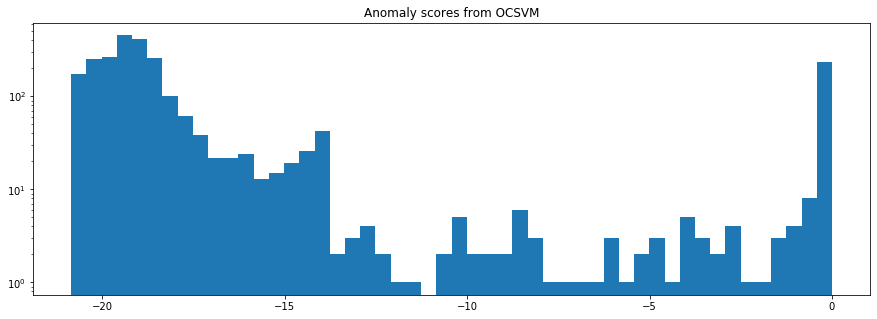

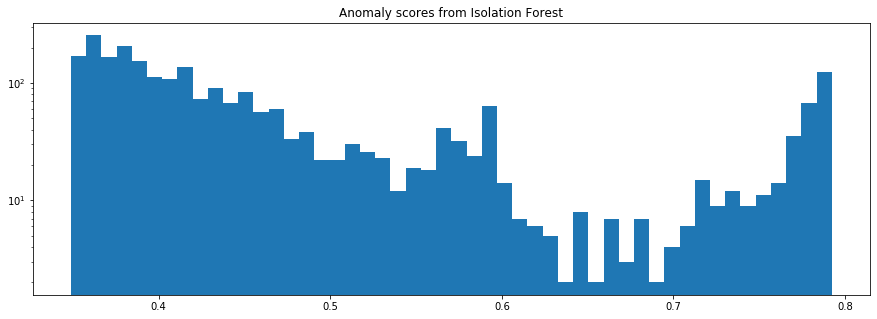

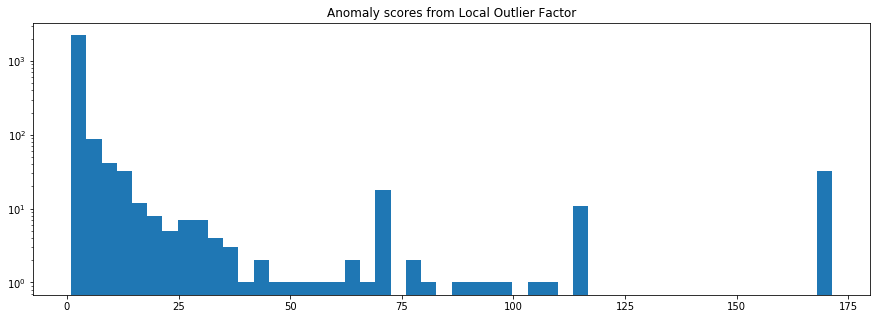

In [68]:
ocsvm, _ = ocsvm_anomaly_detec(basic_stats_train, basic_stats_test, nu=0.05, gamma='scale')
if_ = if_anomaly_detec(basic_stats_train, basic_stats_test, contamination=0.05)
lof = lof_anomaly_detec(basic_stats_train, basic_stats_test, novelty=True, contamination=0.05, n_neighbors=50)

Once again OCSVM seems to be the most efficient anomaly detection algorithm on this data.

## Fourrier Filtering

Let's first try to denoise our signals. This way we are hoping to better caracterize the 'real' acceleration caracteristics. Denoising is used in many of the papers read and the denoising function using Fourrier space is inspired by a public kaggle code (see bibliographie).

In [69]:
# denoise train and test 
X_train_denoised = xtrain.copy()
X_test_denoised = xtest.copy()

# train
for obs in range(len(xtrain)):
        # Apply filter_signal function to the data in each series
        denoised_data = filter_signal(xtrain[obs]) 
        X_train_denoised[obs] = denoised_data

for obs in range(len(xtest)):
        # Apply filter_signal function to the data in each series
        denoised_data = filter_signal(xtest[obs])   
        X_test_denoised[obs] = denoised_data


In [70]:
df_train_denoised = pd.DataFrame(X_train_denoised)
df_test_denoised = pd.DataFrame(X_test_denoised)

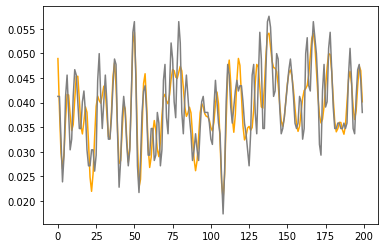

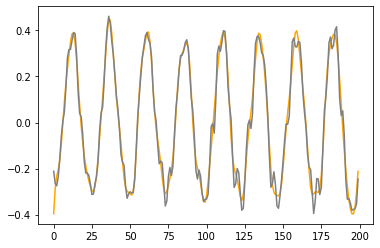

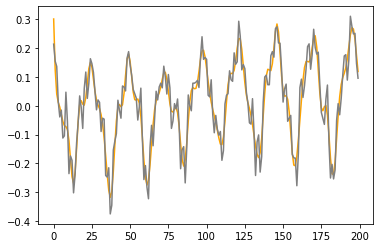

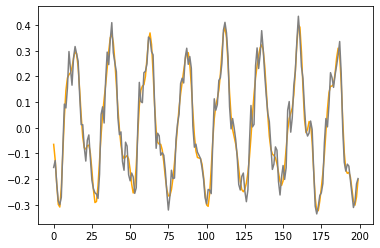

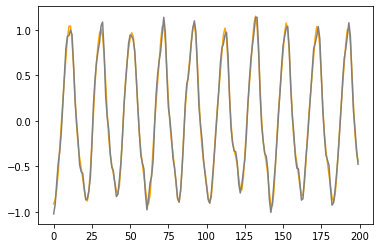

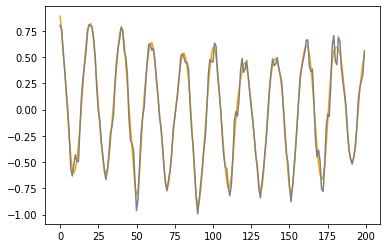

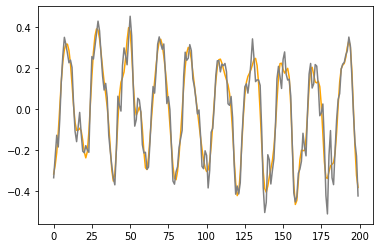

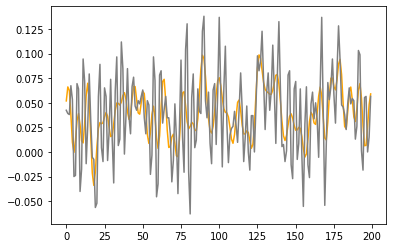

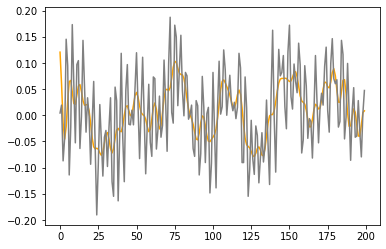

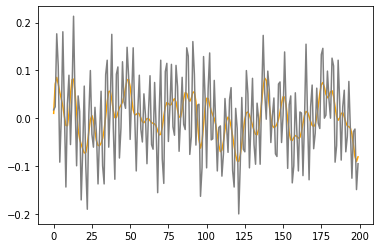

In [71]:
for i in range(10):
    plt.figure()
    plt.plot(X_train_denoised[i][:200], c='orange')
    plt.plot(xtrain[i][:200], c='grey')
    plt.show()

In [72]:
mean_train_denoised, median_train_denoised, std_train_denoised = mean_med_std_train(df_train_denoised)

In [73]:
df_basic_stats_train_denoised = create_basic_stats2(df_train_denoised, mean_train=mean_train_denoised, median_train=median_train_denoised, std_train=std_train_denoised)
df_basic_stats_test_denoised = create_basic_stats2(df_test_denoised, mean_train=mean_train_denoised, median_train=median_train_denoised, std_train=std_train_denoised)
    
df_basic_stats_train_selec = df_basic_stats_train_denoised[[ "n_neg", "median", "percentile_70", "under_2sd", "percentile_30"]]
df_basic_stats_test_selec = df_basic_stats_test_denoised[[ "n_neg", "median", "percentile_70", "under_2sd", "percentile_30"]]

basic_stats_train = df_basic_stats_train_selec.to_numpy()
basic_stats_test = df_basic_stats_test_selec.to_numpy()

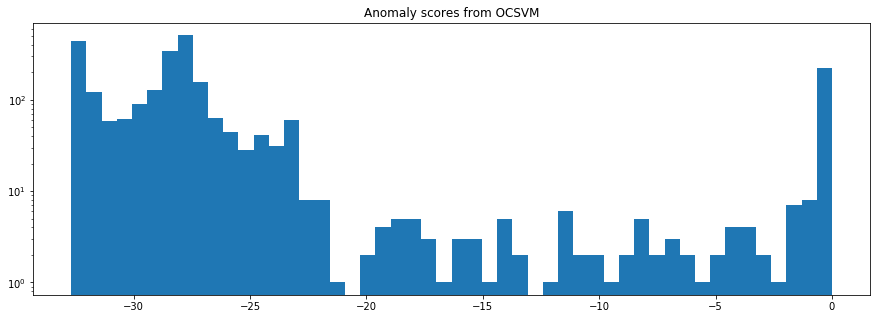

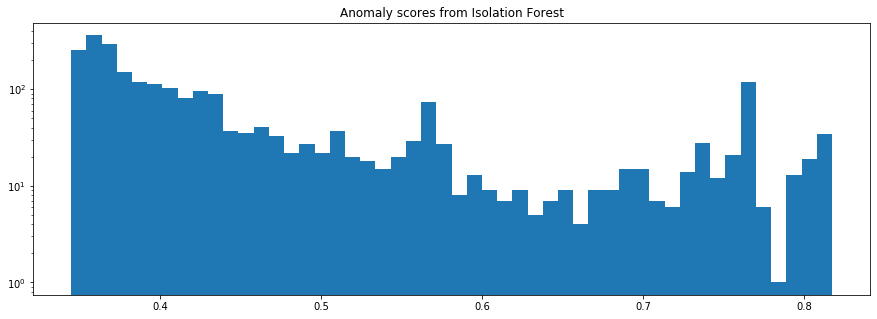

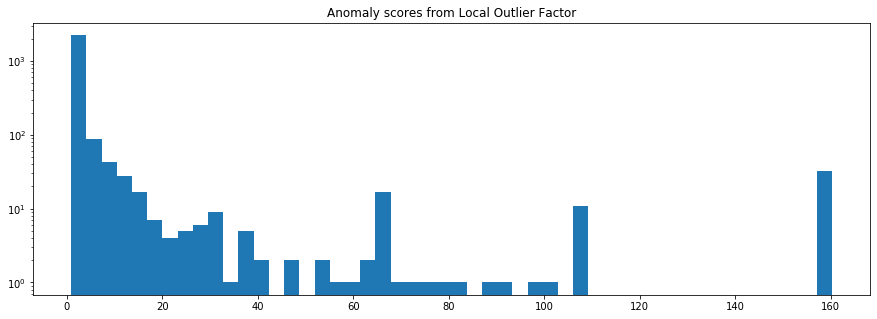

In [74]:
ocsvm, _ = ocsvm_anomaly_detec(basic_stats_train, basic_stats_test, nu=0.05, gamma='scale')
if_ = if_anomaly_detec(basic_stats_train, basic_stats_test, contamination=0.05)
lof = lof_anomaly_detec(basic_stats_train, basic_stats_test, novelty=True, contamination=0.05, n_neighbors=50)

## Anomaly detection on smaller windows

In [75]:
#anomaly detection on 3 seconds windows
freq = 1024
ocsvm_sec = []
if_sec = []
lof_sec = []
std_scaler = StandardScaler()
for sec in range (0,60, 3):
    combined = []
    print("sec ", sec)
    idx_start= (sec*freq)
    idx_end = (sec+3)*(freq)
    #print(idx_start, idx_end)
    df_sec = pd.DataFrame(df_train_denoised.iloc[:, idx_start:idx_end])
    #print(df_sec.shape)
    df_sec_test = pd.DataFrame(df_test_denoised.iloc[:, idx_start:idx_end])
    df_basic_stats_train = create_basic_stats2(df_sec)
    df_basic_stats_test = create_basic_stats2(df_sec_test)
    
    df_basic_stats_train_selec = df_basic_stats_train[[ "n_neg", "median", "percentile_70", "under_2sd", "percentile_30"]]
    df_basic_stats_test_selec = df_basic_stats_test[[ "n_neg", "median", "percentile_70", "under_2sd", "percentile_30"]]

    basic_stats_train = df_basic_stats_train_selec.to_numpy()
    basic_stats_test = df_basic_stats_test_selec.to_numpy()
    
    if_ = if_anomaly_detec(basic_stats_train, basic_stats_test, contamination=0.05, graph=False)
    lof = lof_anomaly_detec(basic_stats_train, basic_stats_test, novelty=True, contamination=0.05, n_neighbors=50, graph=False)
    ocsvm, _ = ocsvm_anomaly_detec(basic_stats_train, basic_stats_test, nu=0.08, graph=False)
    
    ocsvm_sec.append(ocsvm)
    if_sec.append(if_)
    lof_sec.append(lof)

sec  0
sec  3
sec  6
sec  9
sec  12
sec  15
sec  18
sec  21
sec  24
sec  27
sec  30
sec  33
sec  36
sec  39
sec  42
sec  45
sec  48
sec  51
sec  54
sec  57


In [77]:
ocsvm_sec_np = np.array(ocsvm_sec)
ocsvm_sec_np = ocsvm_sec_np.reshape(20,2511).T

if_sec_np = np.array(if_sec)
if_sec_np = if_sec_np.reshape(20,2511).T

lof_sec_np = np.array(lof_sec)
lof_sec_np = lof_sec_np.reshape(20,2511).T


comb_by_average_ocsvm = average(ocsvm_sec_np)
comb_by_average_if = average(if_sec_np)
comb_by_average_lof = average(lof_sec_np)


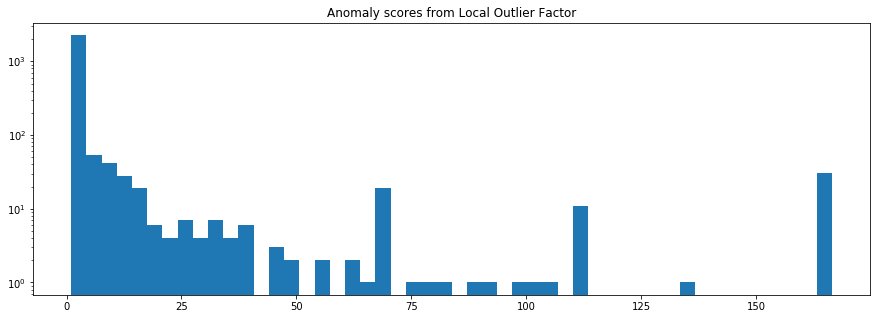

In [78]:
plt.figure(figsize=(15, 5))
plt.title("Anomaly scores from Local Outlier Factor")
plt.hist(comb_by_average_lof, bins=50, log=True)
plt.show()

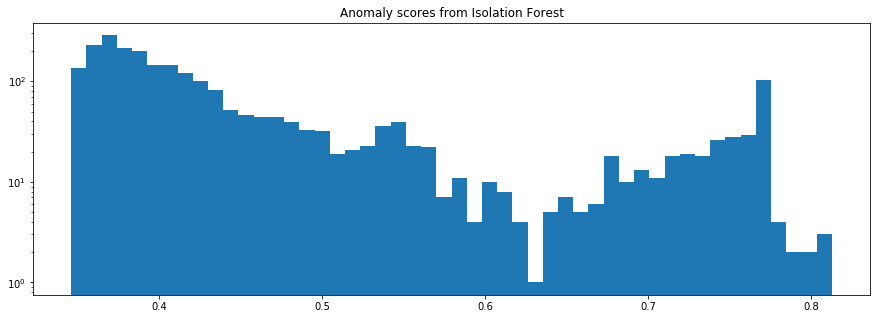

In [79]:
plt.figure(figsize=(15, 5))
plt.title("Anomaly scores from Isolation Forest")
plt.hist(comb_by_average_if, bins=50, log=True)
plt.show()

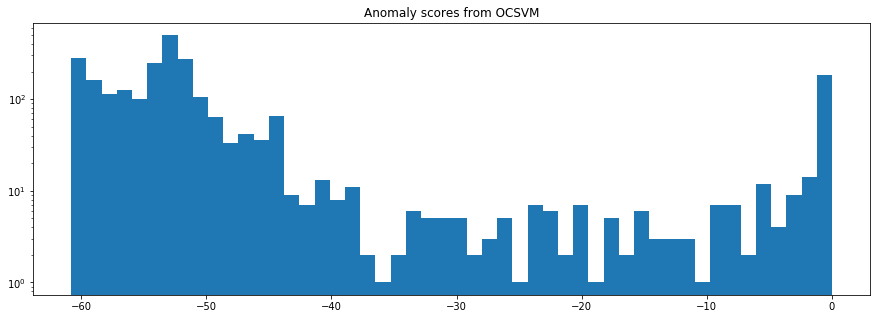

In [80]:
plt.figure(figsize=(15, 5))
plt.title("Anomaly scores from OCSVM")
plt.hist(comb_by_average_ocsvm, bins=50, log=True)
plt.show()

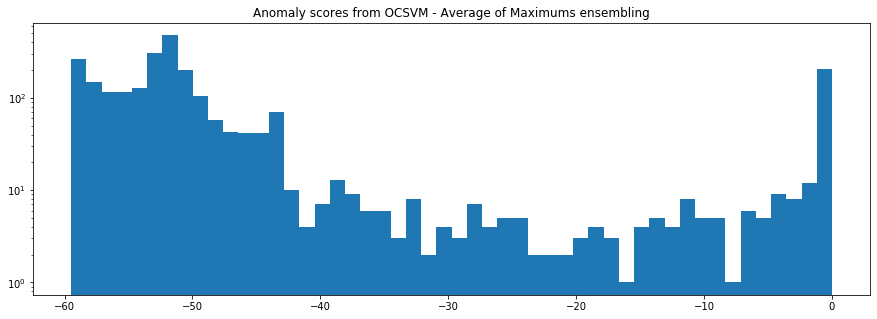

In [81]:

comb_by_aom = aom(ocsvm_sec_np, 10) 
plt.figure(figsize=(15, 5))
plt.title("Anomaly scores from OCSVM - Average of Maximums ensembling")
plt.hist(comb_by_aom, bins=50, log=True)
plt.show()

## Wavelet Transforms

In [ ]:
# Wavelet decomposition of both train and test observations, using a Symlet 4.

wavelet_window = len(xtrain[0])
w = pywt.Wavelet('sym4')
# Max decomposition level.
maxlev = pywt.dwt_max_level(wavelet_window, w.dec_len)  
wavelet_coefficients_train = []
wavelet_observation_train = []
wavelet_mean_coeffs_0_level_train =[]
wavelet_mean_coeffs_1_level_train =[]
wavelet_mean_coeffs_2_level_train =[]
wavelet_mean_coeffs_3_level_train =[]
wavelet_mean_coeffs_4_level_train =[]
wavelet_mean_coeffs_5_level_train =[]
wavelet_mean_coeffs_6_level_train =[]
wavelet_mean_coeffs_7_level_train =[]
wavelet_mean_coeffs_8_level_train =[]
wavelet_mean_coeffs_9_level_train =[]
wavelet_mean_coeffs_10_level_train =[]
wavelet_mean_coeffs_11_level_train =[]
wavelet_mean_coeffs_12_level_train =[]
wavelet_mean_coeffs_13_level_train =[]

for obs in range(len(xtrain)):
    # Processing wavelet decomposition
    signal = xtrain[obs]
    coeffs = pywt.wavedec(signal, wavelet=w, level=maxlev)    
    # Store the coefficients
    wavelet_mean_coeffs_0_level_train.append(coeffs[0])
    wavelet_mean_coeffs_1_level_train.append(coeffs[1])
    wavelet_mean_coeffs_2_level_train.append(coeffs[2])
    wavelet_mean_coeffs_3_level_train.append(coeffs[3])
    wavelet_mean_coeffs_4_level_train.append(coeffs[4])
    wavelet_mean_coeffs_5_level_train.append(coeffs[5])
    wavelet_mean_coeffs_6_level_train.append(coeffs[6])
    wavelet_mean_coeffs_7_level_train.append(coeffs[7])
    wavelet_mean_coeffs_8_level_train.append(coeffs[8])
    wavelet_mean_coeffs_9_level_train.append(coeffs[9])
    wavelet_mean_coeffs_10_level_train.append(coeffs[10])
    wavelet_mean_coeffs_11_level_train.append(coeffs[11])
    wavelet_mean_coeffs_12_level_train.append(coeffs[12])
    wavelet_mean_coeffs_13_level_train.append(coeffs[13])

# Pareil sur le jeu de test

wavelet_window = len(xtest[0])
# Max decomposition level.
maxlev = pywt.dwt_max_level(wavelet_window, w.dec_len)  
wavelet_coefficients_train = []
wavelet_observation_train = []
wavelet_mean_coeffs_0_level_test=[]
wavelet_mean_coeffs_1_level_test =[]
wavelet_mean_coeffs_2_level_test=[]
wavelet_mean_coeffs_3_level_test =[]
wavelet_mean_coeffs_4_level_test=[]
wavelet_mean_coeffs_5_level_test =[]
wavelet_mean_coeffs_6_level_test=[]
wavelet_mean_coeffs_7_level_test =[]
wavelet_mean_coeffs_8_level_test=[]
wavelet_mean_coeffs_9_level_test =[]
wavelet_mean_coeffs_10_level_test=[]
wavelet_mean_coeffs_11_level_test =[]
wavelet_mean_coeffs_12_level_test=[]
wavelet_mean_coeffs_13_level_test =[]


for obs in range(len(xtest)):
    # Processing wavelet decomposition
    signal = xtest[obs]
    coeffs = pywt.wavedec(signal, wavelet=w, level=maxlev)    

    wavelet_mean_coeffs_0_level_test.append(coeffs[0])
    wavelet_mean_coeffs_1_level_test.append(coeffs[1])
    wavelet_mean_coeffs_2_level_test.append(coeffs[2])
    wavelet_mean_coeffs_3_level_test.append(coeffs[3])
    wavelet_mean_coeffs_4_level_test.append(coeffs[4])
    wavelet_mean_coeffs_5_level_test.append(coeffs[5])
    wavelet_mean_coeffs_6_level_test.append(coeffs[6])
    wavelet_mean_coeffs_7_level_test.append(coeffs[7])
    wavelet_mean_coeffs_8_level_test.append(coeffs[8])
    wavelet_mean_coeffs_9_level_test.append(coeffs[9])
    wavelet_mean_coeffs_10_level_test.append(coeffs[10])
    wavelet_mean_coeffs_11_level_test.append(coeffs[11])
    wavelet_mean_coeffs_12_level_test.append(coeffs[12])
    wavelet_mean_coeffs_13_level_test.append(coeffs[13])

In [ ]:
# Convert to dataframe to call feature creation function : function that extracts median, 5th and 95th percentiles from the list of coefficients
df_train_wav_0 = pd.DataFrame(wavelet_mean_coeffs_0_level_train)
df_train_wav_0_stats = create_basic_stats_wav(df_train_wav_0)
df_train_wav_1 = pd.DataFrame(wavelet_mean_coeffs_1_level_train)
df_train_wav_1_stats = create_basic_stats_wav(df_train_wav_1)
df_train_wav_2 = pd.DataFrame(wavelet_mean_coeffs_2_level_train)
df_train_wav_2_stats = create_basic_stats_wav(df_train_wav_2)
df_train_wav_3 = pd.DataFrame(wavelet_mean_coeffs_3_level_train)
df_train_wav_3_stats = create_basic_stats_wav(df_train_wav_3)

df_train_wav_4 = pd.DataFrame(wavelet_mean_coeffs_4_level_train)
df_train_wav_4_stats = create_basic_stats_wav(df_train_wav_4)
df_train_wav_5 = pd.DataFrame(wavelet_mean_coeffs_5_level_train)
df_train_wav_5_stats = create_basic_stats_wav(df_train_wav_5)
df_train_wav_6 = pd.DataFrame(wavelet_mean_coeffs_6_level_train)
df_train_wav_6_stats = create_basic_stats_wav(df_train_wav_6)
df_train_wav_7 = pd.DataFrame(wavelet_mean_coeffs_7_level_train)
df_train_wav_7_stats = create_basic_stats_wav(df_train_wav_7)
df_train_wav_8 = pd.DataFrame(wavelet_mean_coeffs_8_level_train)
df_train_wav_8_stats = create_basic_stats_wav(df_train_wav_8)
df_train_wav_9 = pd.DataFrame(wavelet_mean_coeffs_9_level_train)
df_train_wav_9_stats = create_basic_stats_wav(df_train_wav_9)
df_train_wav_10 = pd.DataFrame(wavelet_mean_coeffs_10_level_train)
df_train_wav_10_stats = create_basic_stats_wav(df_train_wav_10)
df_train_wav_11 = pd.DataFrame(wavelet_mean_coeffs_11_level_train)
df_train_wav_11_stats = create_basic_stats_wav(df_train_wav_11)
df_train_wav_12 = pd.DataFrame(wavelet_mean_coeffs_12_level_train)
df_train_wav_12_stats = create_basic_stats_wav(df_train_wav_12)
df_train_wav_13 = pd.DataFrame(wavelet_mean_coeffs_13_level_train)
df_train_wav_13_stats = create_basic_stats_wav(df_train_wav_13)

df_test_wav_0 = pd.DataFrame(wavelet_mean_coeffs_0_level_test)
df_test_wav_0_stats = create_basic_stats_wav(df_test_wav_0)
df_test_wav_1 = pd.DataFrame(wavelet_mean_coeffs_1_level_test)
df_test_wav_1_stats = create_basic_stats_wav(df_test_wav_1)
df_test_wav_2 = pd.DataFrame(wavelet_mean_coeffs_2_level_test)
df_test_wav_2_stats = create_basic_stats_wav(df_test_wav_2)
df_test_wav_3 = pd.DataFrame(wavelet_mean_coeffs_3_level_test)
df_test_wav_3_stats = create_basic_stats_wav(df_test_wav_3)
df_test_wav_4 = pd.DataFrame(wavelet_mean_coeffs_4_level_test)
df_test_wav_4_stats = create_basic_stats_wav(df_test_wav_4)
df_test_wav_5 = pd.DataFrame(wavelet_mean_coeffs_5_level_test)
df_test_wav_5_stats = create_basic_stats_wav(df_test_wav_5)
df_test_wav_6 = pd.DataFrame(wavelet_mean_coeffs_6_level_test)
df_test_wav_6_stats = create_basic_stats_wav(df_test_wav_6)
df_test_wav_7 = pd.DataFrame(wavelet_mean_coeffs_7_level_test)
df_test_wav_7_stats = create_basic_stats_wav(df_test_wav_7)
df_test_wav_8 = pd.DataFrame(wavelet_mean_coeffs_8_level_test)
df_test_wav_8_stats = create_basic_stats_wav(df_test_wav_8)
df_test_wav_9 = pd.DataFrame(wavelet_mean_coeffs_9_level_test)
df_test_wav_9_stats = create_basic_stats_wav(df_test_wav_9)
df_test_wav_10 = pd.DataFrame(wavelet_mean_coeffs_10_level_test)
df_test_wav_10_stats = create_basic_stats_wav(df_test_wav_10)
df_test_wav_11 = pd.DataFrame(wavelet_mean_coeffs_11_level_test)
df_test_wav_11_stats = create_basic_stats_wav(df_test_wav_11)
df_test_wav_12 = pd.DataFrame(wavelet_mean_coeffs_12_level_test)
df_test_wav_12_stats = create_basic_stats_wav(df_test_wav_12)
df_test_wav_13 = pd.DataFrame(wavelet_mean_coeffs_13_level_test)
df_test_wav_13_stats = create_basic_stats_wav(df_test_wav_13)

In [ ]:
# Features to keep by level : median is looked at for most dilated wavelets as we have few coefficients for those levels
# Level 0
col0 = ["median"]
# Level 1 to 5
col1 = ["median", "5perc", "95perc"]
# Levels higher
cols_upper_levels = ["5perc", "95perc"]

In [ ]:
# Construction of features for each level of the wavelet decomposition
train_wav_0 = df_train_wav_0_stats[list(col0)]
test_wav_0 = df_test_wav_0_stats[list(col0)]

train_wav_1 = df_train_wav_1_stats[list(col1)]
test_wav_1 = df_test_wav_1_stats[list(col1)]

train_wav_2 = df_train_wav_2_stats[list(col1)]
test_wav_2 = df_test_wav_2_stats[list(col1)]

train_wav_3 = df_train_wav_3_stats[list(col1)]
test_wav_3 = df_test_wav_3_stats[list(col1)]

train_wav_4 = df_train_wav_4_stats[list(col1)]
test_wav_4 = df_test_wav_4_stats[list(col1)]

train_wav_5 = df_train_wav_5_stats[list(col1)]
test_wav_5 = df_test_wav_5_stats[list(col1)]

train_wav_6 = df_train_wav_6_stats[list(cols_upper_levels)]
test_wav_6 = df_test_wav_6_stats[list(cols_upper_levels)]

train_wav_7 = df_train_wav_7_stats[list(cols_upper_levels)]
test_wav_7 = df_test_wav_7_stats[list(cols_upper_levels)]

train_wav_8 = df_train_wav_8_stats[list(cols_upper_levels)]
test_wav_8 = df_test_wav_8_stats[list(cols_upper_levels)]

train_wav_9 = df_train_wav_9_stats[list(cols_upper_levels)]
test_wav_9 = df_test_wav_9_stats[list(cols_upper_levels)]

train_wav_10 = df_train_wav_11_stats[list(cols_upper_levels)]
test_wav_10 = df_test_wav_11_stats[list(cols_upper_levels)]

train_wav_11 = df_train_wav_11_stats[list(cols_upper_levels)]
test_wav_11 = df_test_wav_11_stats[list(cols_upper_levels)]

train_wav_12 = df_train_wav_11_stats[list(cols_upper_levels)]
test_wav_12 = df_test_wav_11_stats[list(cols_upper_levels)]

train_wav_13 = df_train_wav_11_stats[list(cols_upper_levels)]
test_wav_13 = df_test_wav_11_stats[list(cols_upper_levels)]

We keep info on extreme coefficient for each level of decomposition of the wavelet. Each level corresponding to a different dilation of the wavelet gives us information on different frequences from the signal. For first levels the wavelet are very large and therefore return a lower number of coefficients which is why we also keep the median as a feature.
We will now concatenate all these features and try running a One class SVM anomaly detection on them.

In [ ]:
# Concatenation of the info taken from each level of dilation of the wavelet
df_test_wav = pd.concat([test_wav_0,test_wav_1,test_wav_2, test_wav_3, test_wav_4, 
                  test_wav_5, test_wav_6, test_wav_7, test_wav_8, test_wav_9, test_wav_10,
                  test_wav_11 , test_wav_12, test_wav_13], axis=1)
df_train_wav = pd.concat([train_wav_0, train_wav_1, train_wav_2, train_wav_3, train_wav_4,
                   train_wav_5, train_wav_6, train_wav_7, train_wav_8, train_wav_9, train_wav_10,
                  train_wav_11, train_wav_12, train_wav_13], axis=1)


In [ ]:
### train_wav = train.to_numpy()
test_wav = test.to_numpy()

In [ ]:
ocsvm = ocsvm_anomaly_detec(coeff_stats_train, coeff_stats_test, nu=0.05)
lof = lof_anomaly_detec(coeff_stats_train, coeff_stats_test, n_neighbors=50, contamination=0.05, novelty = True)
if_ = if_anomaly_detec(coeff_stats_train, coeff_stats_test, contamination=0.01)
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("OCSVM anomaly scores")
plt.hist(ocsvm, bins=50, log=True)
plt.subplot(132)
plt.title("LOF anomaly scores")
plt.hist(lof, bins=50, log=True)
plt.subplot(133)
plt.title("IF anomaly scores")
plt.hist(if_, bins=50, log=True)
plt.show()

Isolation forrest doesnt seperate our scores like we would like for it too. We will not use those scores.

## PyOd PCA for anomaly detection

In [83]:
df_basic_stats_train = create_basic_stats2(df)

In [84]:
df_basic_stats_test = create_basic_stats2(df_test, mean_train, std_train)

In [86]:
freq = 1024
ocsvm_sec = []
pred_sec = []
std_scaler = StandardScaler()
for sec in range (0,60):
    combined = []
    print("sec ", sec)
    idx_start= (sec*freq)
    idx_end = (sec+1)*(freq)
    #print(idx_start, idx_end)
    df_sec = pd.DataFrame(df.iloc[:, idx_start:idx_end])
    #print(df_sec.shape)
    df_sec_test = pd.DataFrame(df_test.iloc[:, idx_start:idx_end])
    df_basic_stats_train = create_basic_stats2(df_sec)
    df_basic_stats_test = create_basic_stats2(df_sec_test)
    
    df_basic_stats_train_selec = df_basic_stats_train[[ "n_neg","mean","std","extremes_spread", "median", "percentile_70", "under_2sd_train", "percentile_30", "n_values_in_range_abs15"]]
    df_basic_stats_test_selec = df_basic_stats_test[[ "n_neg","mean","std","extremes_spread", "median", "percentile_70", "under_2sd_train", "percentile_30", "n_values_in_range_abs15"]]

    basic_stats_train = df_basic_stats_train_selec.to_numpy()
    basic_stats_test = df_basic_stats_test_selec.to_numpy()
    
    clf = PCA(n_components=1)
    clf.fit(basic_stats_train)
    train = clf.decision_scores_
    
    pred = clf.decision_function(basic_stats_test)

    train_scores_norm, test_scores_norm = standardizer(train.reshape(-1, 1), pred.reshape(-1, 1))
    pred_sec.append(test_scores_norm)

    ocsvm, _ = ocsvm_anomaly_detec(basic_stats_train, basic_stats_test, nu=0.08, graph=False)
    ocsvm_sec.append(ocsvm)

    

sec  0
sec  1
sec  2
sec  3
sec  4
sec  5
sec  6
sec  7
sec  8
sec  9
sec  10
sec  11
sec  12
sec  13
sec  14
sec  15
sec  16
sec  17
sec  18
sec  19
sec  20
sec  21
sec  22
sec  23
sec  24
sec  25
sec  26
sec  27
sec  28
sec  29
sec  30
sec  31
sec  32
sec  33
sec  34
sec  35
sec  36
sec  37
sec  38
sec  39
sec  40
sec  41
sec  42
sec  43
sec  44
sec  45
sec  46
sec  47
sec  48
sec  49
sec  50
sec  51
sec  52
sec  53
sec  54
sec  55
sec  56
sec  57
sec  58
sec  59


In [88]:
pca_pred_np = np.array(pred_sec)
pca_pred_np= pca_pred_np.reshape(60,2511).T
#pca_pred_np.shape

comb_by_average = average(pca_pred_np)
comb_by_aom = aom(pca_pred_np, 20) # 5 groups


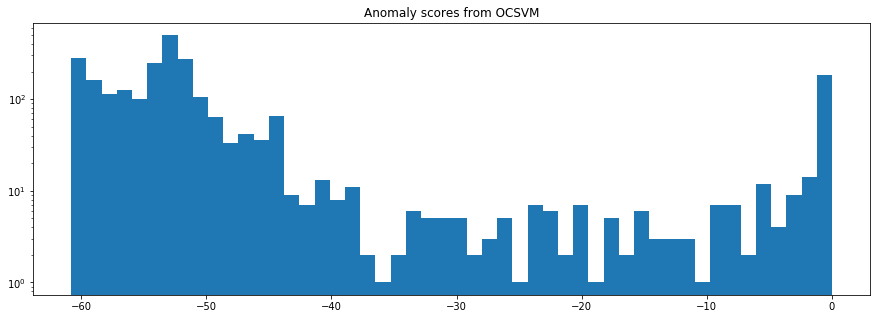

In [89]:
plt.figure(figsize=(15, 5))
plt.title("Anomaly scores from OCSVM")
plt.hist(comb_by_average_ocsvm, bins=50, log=True)
plt.show()

## Eliminating less normal training data

In [ ]:
ocsvm, train_scores = ocsvm_anomaly_detec(basic_stats_train, basic_stats_test, nu=0.05)
lof = lof_anomaly_detec(basic_stats_train, basic_stats_test, n_neighbors=50, contamination=0.05, novelty = True)
if_ = if_anomaly_detec(basic_stats_train, basic_stats_test, contamination=0.01)

In [ ]:
plt.hist(train_scores)

In [ ]:
plt.hist(ocsvm)

In [ ]:
best = np.argsort(train_scores)[167:-167]

In [ ]:
np.min(train_scores)

In [ ]:
train_scores[418]

In [ ]:
desired_indices = []
for i in range(len(df)):
    if i in best:
        desired_indices.append(i)
desired_df = df.iloc[desired_indices]

In [ ]:
desired_df

In [ ]:
train_best = create_basic_stats2(desired_df)

In [ ]:
df_basic_stats_train_selec_best = train_best[list(cols)]

In [ ]:
basic_stats_train_best = df_basic_stats_train_selec_best.to_numpy()

In [ ]:
ocsvm3, train_scores2 = ocsvm_anomaly_detec(basic_stats_train_best, basic_stats_test, nu=0.01)


## PCA dimension reduction (Pavlo)

In [ ]:
# PCA transform
pca1 = PCA(n_components = 10, whiten = True)

pca1.fit(xtrain[:100,:])
xtrain_fpca = pca1.fit_transform(xtrain[:100,:])
# Fit the low-dimensional method
lof1 = LocalOutlierFactor(n_neighbors = 5 ,contamination = 0.0001, novelty = True)
lof1.fit(xtrain_fpca)
# Calculate anomaly score on the (PCA-transformed) test data
xtest_fpca = pca1.fit_transform(xtest)
sscore = -lof1.score_samples(xtest_fpca)
print(sscore[:100])

It was interresting to notice that this simple code trained only on the first 100 accelerations from the train set already gave a .73 on the leader board. This tends to show that the test sample might be possible to classify as abnormal using only a few observations. This of course would come down to playing the lottery and absolutely not give a robust model.

FPCA was tried with no concluding results.

## Anomaly Detection Algorithms

### Local Outlier Factor

In [47]:
def lof_anomaly_detec(train, test, n_neighbors, contamination, novelty = True, graph=True):

    lof1 = LocalOutlierFactor(n_neighbors = n_neighbors,
                              contamination = contamination, 
                              novelty=novelty)
    lof1.fit(train)
    prof_scores = -lof1.score_samples(train)
    sscore_lof = -lof1.score_samples(test)
    pred = lof1.predict(test)
    if graph:
        plt.figure(figsize=(15, 5))
        plt.title("Anomaly scores from Local Outlier Factor")
        plt.hist(sscore_lof, bins=50, log=True)
        plt.show()
    return sscore_lof 

### Isolation Forrest

In [48]:
def if_anomaly_detec(train, test, contamination=0, graph=True):
    
    if1 = IsolationForest(contamination = contamination)
    if1.fit(train)
    prof_scores = -if1.score_samples(train)
    sscore_if = -if1.score_samples(test)
    if graph:
        plt.figure(figsize=(15, 5))
        plt.title("Anomaly scores from Isolation Forest")
        plt.hist(sscore_if, bins=50, log=True)
        plt.show()
    return sscore_if

### One Class Support Vector Machine

In [49]:
def ocsvm_anomaly_detec(train, test, nu=0.005, gamma='scale', graph=True):
    
    ocsvm1 = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
    ocsvm1.fit(train)
    train_scores = -ocsvm1.score_samples(train)
    sscore_ocsvm = -ocsvm1.score_samples(test)
    if graph:
        plt.figure(figsize=(15, 5))
        plt.title("Anomaly scores from OCSVM")
        plt.hist(sscore_ocsvm, bins=50, log=True)
        plt.show()
    
    return sscore_ocsvm, train_scores

## Ensembling with rank (wavelet and raw statistics models)

In [ ]:
if_ranked_scores = rankdata(best_score_if, method='ordinal')
ocsvm_ranked_scores = rankdata(best_score_ocsvm, method='ordinal')
lof_ranked_scores = rankdata(best_score_lof, method='ordinal')

In [ ]:
wav_if_ranked = rankdata(sscore_if_wav, method='ordinal')
wav_ocsvm_ranked = rankdata(sscore_ocsvm_wav, method='ordinal')

## Saving results for soumissions

In [ ]:
# Save the anomaly scores to file
np.savetxt('ytest_challenge_student.csv', sscore, fmt = '%1.6f', delimiter=',')

## Bibliographie

Functional Isolation Forest
Guillaume Staerman, Pavlo Mozharovskyi, Stéphan Clémençon, Florence d'Alché-Buc.
(submitted), 2019.
https://arxiv.org/abs/1904.04573

Learning Fair Scoring Functions: Fairness Definitions, Algorithms and Generalization Bounds for Bipartite Ranking

Functional Data Analysis, J.O. Ramsay, B.W. Silverman

How to Evaluate the Quality of Unsupervised Anomaly Detection Algorithms?, Nicolas GOIX

https://ngoix.github.io/slides_jussieu.pdf

Anomaly Detection with Generative Adversarial
Networks for Multivariate Time Series, Dan Li, Dacheng Chen, Jonathan Goh, and See-Kiong Ng

Stéphan Clémençon, Alexandre Gramfort, Anne Sabourin, Albert Thomas. Empirical Minimum Volume Set on the Sphere: A Canonical Anomaly Detection Method. AISTATS, Jun 2017, Fort Lauderdale, United States. ⟨hal-02288463⟩

Albert Thomas, Vincent Feuillard, Alexandre Gramfort. Calibration of One-Class SVM for MV set estimation. IEEE DSAA' 2015, Oct 2015, Paris, France. ⟨hal-01188294⟩

Zhao, Y., Nasrullah, Z. and Li, Z., 2019. PyOD: A Python Toolbox for Scalable Outlier Detection. Journal of machine learning research (JMLR), 20(96), pp.1-7.

https://stackoverflow.com/questions/39951196/how-to-find-values-below-or-above-average
https://towardsdatascience.com/anomaly-detection-with-pyod-b523fc47db9
https://machinelearningmastery.com/clustering-algorithms-with-python
https://github.com/wikistat/High-Dimensional-Deep-Learning/blob/master/AnomalyDetection/Python-Anomaly-Detection.ipynb
https://github.com/rob-med/awesome-TS-anomaly-detection